# Credit Risk Assessment

A credit risk is the risk of default on a debt that may arise from a borrower failing to make required payments. Someone who defaults on their loans can mean a lot of money lost for a financial institution and at the same time, false negatives (i.e. declining a loan when they are capable of repaying the money) can mean money lost from interest. The following is a method for predicting credit risk of a customer. We use the German Credit Data stored in the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)

# Data Munging

The first step is to transform the raw data into another format that is appropriate for analysis.

In [ ]:
import pandas as pd
import dsdbc  #This package required to interface with ODL

#Remove font warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

In [ ]:
#Get ODL database connection
conn = dsdbc.connect(SSID="AZKS")

#Create pandas dataframe directly from "DB" query (really a pysical sequential dataset)
sql = ('(select checkingAccount as "checkingAccount", duration as "duration",creditHistory as "creditHistory",'
         'purpose as "purpose", amount as "amount",savingsAccount as "savingsAccount", employed as "employed",'
         'installmentRate as "installmentRate", gender as "gender", otherDebtors as "otherDebtors",'
         'residentYears as "residentYears", property as "property", age as "age", installmentPlans as "installmentPlans",'
         'housing as "housing", existingCredits as "existingCredits", job as "job", dependents as "dependents",'
         'telephone as "telephone", foreign as "foreign", risk as "risk" from credit_data)')
credit_risk_df = pd.read_sql(sql, conn)

In [3]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,...,property,age,installmentPlans,housing,existingCredits,job,dependents,telephone,foreign,risk
0,A11,6,A34,A43,684,A65,A75,4,A93,A101,...,A121,76,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,12974,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,5996,A61,A74,2,A93,A101,...,A121,58,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,1749,A61,A74,2,A93,A103,...,A122,88,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,12431,A61,A73,3,A93,A101,...,A124,24,A143,A153,2,A173,2,A191,A201,2


As you can see, the German credit dataset is quite unreadable. We will need to map each feature value to its corresponding value that is human readable.

In [4]:
#Ordinal Values have a clear ordering of the variables.
original_ordinal_vals = {"checkingAccount": {"A11": "low", "A12": "medium", "A13": "high", "A14": "none"},
                 "creditHistory": {"A30": "excellent", "A31" : "good", "A32": "okay", "A33": 'bad', "A34": "very bad"},
                 "savingsAccount": {"A61": "low", "A62": "medium", "A63": "high", "A64": "very high", "A65": "none"},
                 "employed": {"A71": "0", "A72": "< 1", "A73": "1-4", "A74": "4-7", "A75": ">= 7"},
                 "job": {"A171": "unemployed/unskilled/non-resident", "A172": "unskilled/resident", "A173": "employed/skilled", "A174": "employed/highly-skilled"}
                }

#Categorical Values do not have an ordering.
original_categorical_vals = {"purpose": {"A40":"car", "A41": "car", "A42":"furniture", "A43": "television", 
                                         "A44": "domestic appliances", "A45": "repairs", "A46": "education/business",
                                         "A48": "education/business", "A49": "education/business", "A410": "other"},
                             "gender": {"A91": "male", "A92": "female", "A93": "male", "A94": "male", "A95": "female"},
                             "otherDebtors": {"A101": "none", "A102": "co-applicant", "A103": "guarantor"},
                             "installmentPlans": {"A141": "yes", "A142": "yes", "A143": "no"},
                             "housing": {"A151": "rent", "A152": "own", "A153": "free"}
                }

#Transform risk value 1 and 2 respectively to 0 and 1
credit_risk_df['risk'] = credit_risk_df['risk'].map({1:0,2:1})

#Delete features that will not make a difference to predicting credit risk.
del credit_risk_df['property']
del credit_risk_df['telephone']
del credit_risk_df['foreign']

credit_risk_df.replace(original_ordinal_vals, inplace=True)
credit_risk_df.replace(original_categorical_vals, inplace=True)

#Convert from DM to USD.
credit_risk_df['amount'] = credit_risk_df['amount'].map(lambda x : ((x * 58)/100))

In [5]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,residentYears,age,installmentPlans,housing,existingCredits,job,dependents,risk
0,low,6,very bad,television,396.72,none,>= 7,4,male,none,4,76,no,own,2,employed/skilled,1,0
1,medium,48,okay,television,7524.92,low,1-4,2,female,none,2,22,no,own,1,employed/skilled,1,1
2,none,12,very bad,education/business,3477.68,low,4-7,2,male,none,3,58,no,own,1,unskilled/resident,2,0
3,low,42,okay,furniture,1014.42,low,4-7,2,male,guarantor,4,88,no,free,1,employed/skilled,2,0
4,low,24,bad,car,7209.98,low,1-4,3,male,none,4,24,no,free,2,employed/skilled,2,1


In [6]:
#Make a copy of the original dataframe before encoding columns.
credit_risk_orig_df = credit_risk_df.copy(deep=True)

In [7]:
#Perform label encoding on ordinal values. Label encoding will still
#capture the ordering of the data.
def handle_ordinal_values(attribute, categories, df):
    cat_str = attribute + 'Cat'
    df[attribute] = pd.Categorical(df[attribute], categories)
    df[cat_str] = df[attribute].cat.codes

ordinal_mapping = {'checkingAccount':["none","low", "medium", "high"], 
                   'creditHistory': ["very bad", "bad", "okay", "good", "excellent"],
                   'savingsAccount': ["none", "low", "medium", "high", "very high"],
                   'employed': ["0", "< 1", "1-4", "4-7", ">= 7"],
                   'job': ["unemployed/unskilled/non-resident","unskilled/resident","employed/skilled","employed/highly-skilled"]}

for feature, feature_vals in ordinal_mapping.items():
    handle_ordinal_values(feature, feature_vals, credit_risk_df)

In [8]:
#Perform one-hot encoding for categorical columns.
credit_risk_df = pd.get_dummies(credit_risk_df, columns=["purpose", "gender", "otherDebtors", "installmentPlans", "housing"])

In [9]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,amount,savingsAccount,employed,installmentRate,residentYears,age,existingCredits,...,gender_female,gender_male,otherDebtors_co-applicant,otherDebtors_guarantor,otherDebtors_none,installmentPlans_no,installmentPlans_yes,housing_free,housing_own,housing_rent
0,low,6,very bad,396.72,none,>= 7,4,4,76,2,...,0,1,0,0,1,1,0,0,1,0
1,medium,48,okay,7524.92,low,1-4,2,2,22,1,...,1,0,0,0,1,1,0,0,1,0
2,none,12,very bad,3477.68,low,4-7,2,3,58,1,...,0,1,0,0,1,1,0,0,1,0
3,low,42,okay,1014.42,low,4-7,2,4,88,1,...,0,1,0,1,0,1,0,1,0,0
4,low,24,bad,7209.98,low,1-4,3,4,24,2,...,0,1,0,0,1,1,0,1,0,0


# Exploratory Analysis

In [10]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#Show the different datatypes within the original dataframe.
credit_risk_orig_df.dtypes

checkingAccount      object
duration              int64
creditHistory        object
purpose              object
amount              float64
savingsAccount       object
employed             object
installmentRate       int64
gender               object
otherDebtors         object
residentYears         int64
age                   int64
installmentPlans     object
housing              object
existingCredits       int64
job                  object
dependents            int64
risk                  int64
dtype: object

In [12]:
#Calculate the averages of the different features and group by risk where 
#0 is good risk and 1 is bad risk.
credit_risk_orig_df.groupby('risk').mean()

,duration,amount,installmentRate,residentYears,age,existingCredits,dependents
risk,,,,,,,
0,19.207143,2511.4464,2.920000,2.842857,60.957143,1.424286,1.155714
1,24.860000,6705.1364,3.096667,2.850000,36.563333,1.366667,1.153333


In [13]:
#Group by risk and aggregate the top value count for each feature.
credit_risk_orig_df.groupby('risk').agg(lambda x: x.value_counts().index[0])

,checkingAccount,duration,creditHistory,purpose,amount,savingsAccount,employed,installmentRate,gender,otherDebtors,residentYears,age,installmentPlans,housing,existingCredits,job,dependents
risk,,,,,,,,,,,,,,,,,
0,none,12,okay,car,2082.20,low,1-4,4,male,none,4,48,no,own,1,employed/skilled,1
1,low,24,okay,car,8828.76,low,1-4,4,male,none,4,41,no,own,1,employed/skilled,1


In [14]:
#Take a close look at the age column statistics
credit_risk_df['age'].describe()

count    1000.000000
mean       53.639000
std        22.411447
min        18.000000
25%        36.000000
50%        48.000000
75%        71.000000
max        99.000000
Name: age, dtype: float64

Judging from the averages for each risk group, we notice that people who request less money and are older are lower risk than those who are 
requesting more money and are younger in age.

  ...So lets use seaborn to plot the data and fit a regression model.

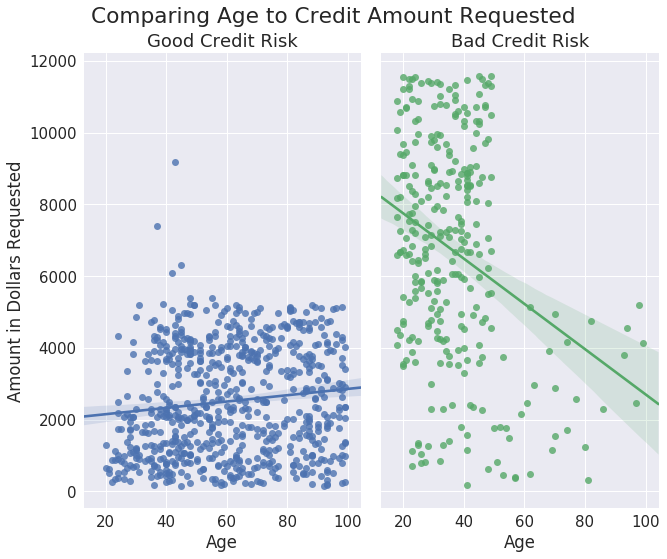

In [15]:
seaborn.set(font="DejaVu Sans",font_scale=1.5)
age_vs_amount_plots = seaborn.lmplot(x='age', y='amount', data=credit_risk_df, hue='risk', col='risk', size=8, aspect=.6)
plt.subplots_adjust(top=0.9)
age_vs_amount_plots.fig.suptitle("Comparing Age to Credit Amount Requested")
age_vs_amount_plots.set_axis_labels("Age", "Amount in Dollars Requested")
titles=['Good Credit Risk', 'Bad Credit Risk']
for ax, title in zip(age_vs_amount_plots.axes.flat, titles):
    ax.set_title(title)

Now we will compare the credit risks of people against the amount they have in savings.

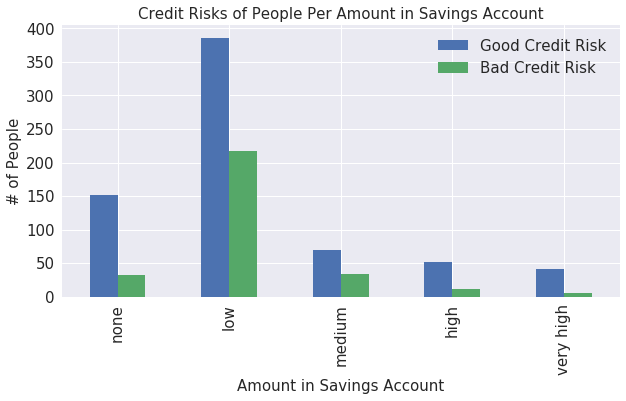

In [16]:
num_risks = credit_risk_df.groupby(['savingsAccount', 'risk']).size()
num_risks_unstacked = num_risks.unstack()
num_risks_unstacked.plot(kind='bar', figsize=(10,5), fontsize=15)
plt.legend(['Good Credit Risk', 'Bad Credit Risk'], fontsize=15)
plt.title("Credit Risks of People Per Amount in Savings Account", fontsize=15)
plt.ylabel("# of People", fontsize=15)
plt.xlabel("Amount in Savings Account", fontsize=15)

This graph shows that most people have little in their savings account and more people are good credit risk than bad. However, a different way of looking at this information is to compare the the ratios or percentages of bad vs good credit risk per amount in savings account.

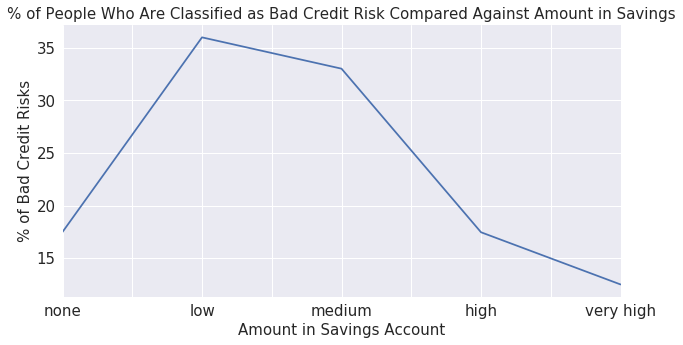

In [17]:
risks_percentages = num_risks.groupby(level=0).apply(lambda x : x / x.sum() * 100).unstack()
risks_percentages[1].plot(kind='line', figsize=(10,5),fontsize=15)
plt.title("% of People Who Are Classified as Bad Credit Risk Compared Against Amount in Savings", fontsize=15)
plt.ylabel("% of Bad Credit Risks", fontsize=15)
plt.xlabel("Amount in Savings Account", fontsize=15)

As we can see, the percentage of people with bad credit risk vs those with good credit risk is lower when they have more money in their savings account.

Let's take a look at the number of dependent and group by good vs bad credit risk

In [18]:
num_dependents = credit_risk_df.groupby(['dependents','risk']).size().unstack()
num_dependents.columns = ['Good Credit Risk', 'Bad Credit Risk']
num_dependents

,Good Credit Risk,Bad Credit Risk
dependents,,
1,591,254
2,109,46


For this particular dataset, there is only 1 or 2 dependents and we don't see much of a correlation here. 

Another visual that might be helpful is seeing what each gender is requesting money for. In this particular dataset, the different requests or purposes include buying a car, furniture, television, repairs, domestic appliances, education/business related incentive, and "other".

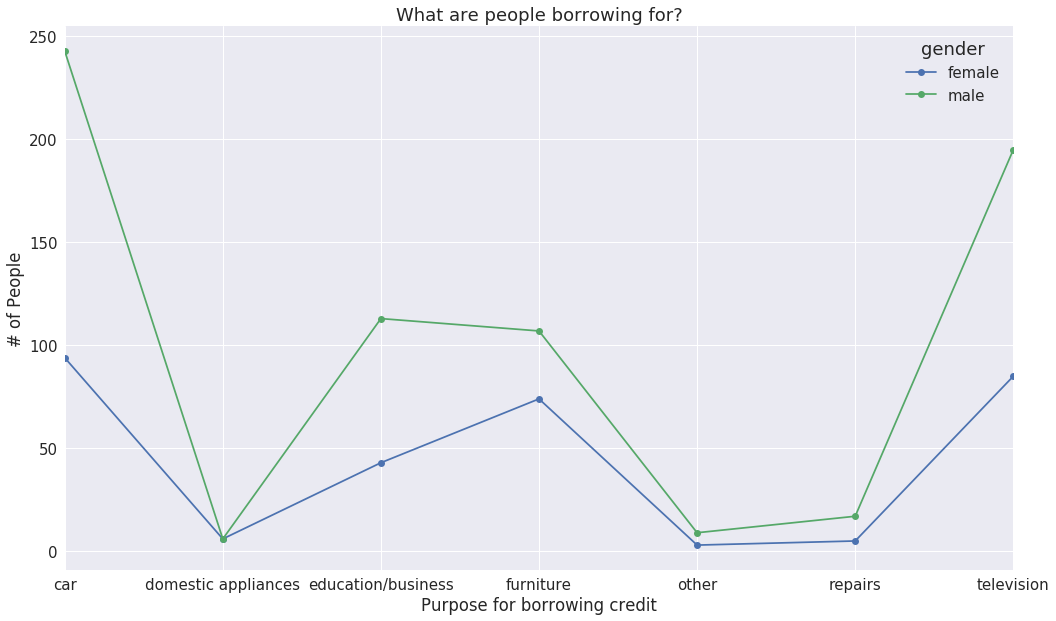

In [19]:
gender_vs_purpose = credit_risk_orig_df.groupby(['purpose', 'gender']).size().unstack()
gender_vs_purpose.plot(kind='line', marker='o', figsize=(17,10))
plt.title("What are people borrowing for?")
plt.ylabel("# of People")
plt.xlabel("Purpose for borrowing credit")

In this dataset, for both males and females, the #1 reason for borrowing is to buy a car. And it seems in all cases besides for domestic appliances, more men are requesting for a loan.

These different visuals help to understand our data better. It is hard to pick out with the human eye all these correlations. Pandas, matplotlib, and seaborn make it incredibly easy to find these underlying patterns.

# Predictive Analysis

Next, we will do some predictive analysis on classifying potential customers as bad or good credit risk. First, we will need to create a model to perform the prediction. For classification models, some classic machine learning algorithms people use are logistic regression and random forest. Here, we will try out both and pick the model that performs better on a new dataset. 

## Logistic Regression

Logistic regression is a good first choice because it is fast, highly scalable, doesn't require much tuning and is easy to regularize. Also, the model outputs a set of probabilities which can be more useful than class labels. Here, we will use scikit-learn to create our models.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [21]:
credit_risk_df.head()

,checkingAccount,duration,creditHistory,amount,savingsAccount,employed,installmentRate,residentYears,age,existingCredits,...,gender_female,gender_male,otherDebtors_co-applicant,otherDebtors_guarantor,otherDebtors_none,installmentPlans_no,installmentPlans_yes,housing_free,housing_own,housing_rent
0,low,6,very bad,396.72,none,>= 7,4,4,76,2,...,0,1,0,0,1,1,0,0,1,0
1,medium,48,okay,7524.92,low,1-4,2,2,22,1,...,1,0,0,0,1,1,0,0,1,0
2,none,12,very bad,3477.68,low,4-7,2,3,58,1,...,0,1,0,0,1,1,0,0,1,0
3,low,42,okay,1014.42,low,4-7,2,4,88,1,...,0,1,0,1,0,1,0,1,0,0
4,low,24,bad,7209.98,low,1-4,3,4,24,2,...,0,1,0,0,1,1,0,1,0,0


In [22]:
# Create train and test dataframes. First we are going to drop the 
# categorical variables and only keep the one-hot encoded versions of them.
credit_risk_df = credit_risk_df.drop(['checkingAccount', 'creditHistory', 'savingsAccount', 'employed', 'job'], axis=1)

X = credit_risk_df.drop('risk', axis=1)
y = credit_risk_df['risk']

In [23]:
#Create the model.
model = LogisticRegression()
#Use cross validation to prevent overfitting. Here we pick 10 fold cross
#validation. i.e. we take out a set of the data to use for test and 
#leave in the rest for training.
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.90 (+/- 0.26)


Let's try to regularize our logistic regression to see if we can increase our accuracy. Here, we try using grid search to perform an exhaustive search over the parameter space.

In [24]:
param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'penalty': ['l1','l2']}
clf = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='neg_log_loss')
clf.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

Let's see what grid search found as the best C and penalty

In [25]:
print(clf.best_params_)

{'C': 0.001, 'penalty': 'l1'}


We will use these values in our logistic regression and see if it improves the accuracy.

In [26]:
C = clf.best_params_['C']
penalty = clf.best_params_['penalty']
model = LogisticRegression(C=C, penalty=penalty)
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.27)


Now we will try Random Forest and see if we can do even better.

## Random Forest

Random Forest is another popular algorithm for both classification and regression. It requires very little tuning and is less prone to overfitting. Random forest is an aggregation of decision tress where each tree classifies an observation in a dataset. Since random forest aggregates many classifiers, it is considered an emsemble method. Using scikit learn again, we will create our random forest for classification and take a look at its accuracy.

In [27]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split

model = RFC(n_estimators = 200)
scores = cross_val_score(model, X,y, cv=10, scoring='accuracy' )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.91 (+/- 0.24)


Sticking with our random forest model, we are now going to fit the model on our training set and then see how well the random forest performs on our test set. The results are shown in the cross-tabulation below.

In [28]:
train, test = train_test_split(credit_risk_df, test_size = 0.3)
model.fit(train.loc[:, train.columns != 'risk'], train['risk'])
preds = model.predict(test.loc[:,train.columns !='risk'])
pd.crosstab(index=test['risk'], columns=preds, rownames=['Actual Value'], colnames=['Predictions'])

Predictions,0,1
Actual Value,,
0,194,5
1,24,77


One advantage of random forest is seeing which features work best for our model. Here we rank the importance of the features:

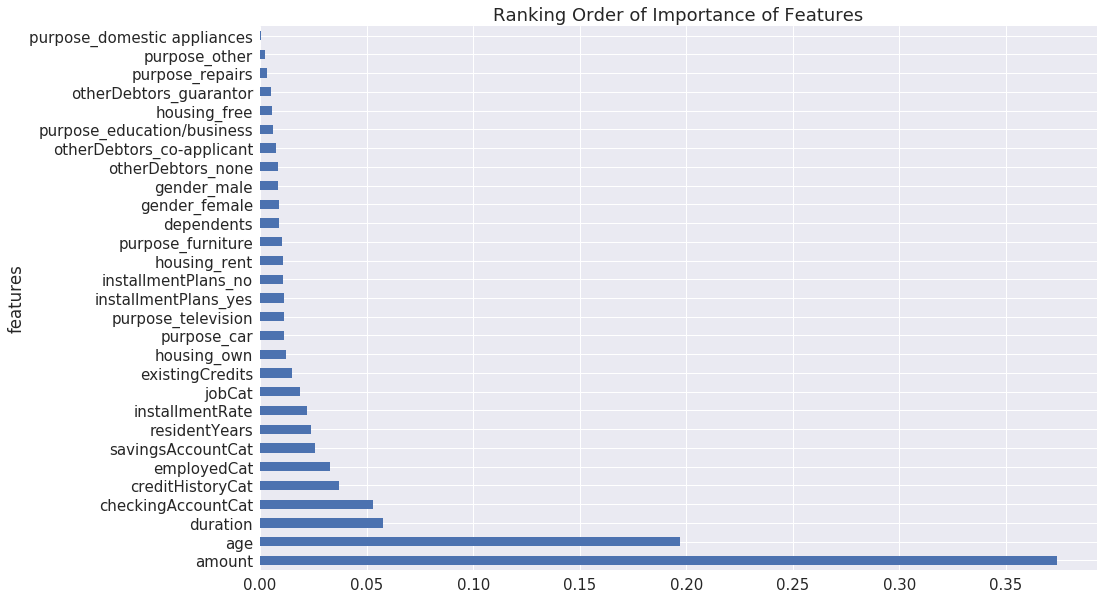

In [29]:
cols = [col for col in train.columns if col not in ['risk']]
importances = pd.DataFrame({'features':cols,'importance_value':model.feature_importances_})
importances = importances.sort_values('importance_value',ascending=False).set_index('features')
importances.plot(figsize=(15,10), kind="barh", legend=False, title="Ranking Order of Importance of Features")

As we can see, amount of money requested, age and the amount of money in their checkings account are the most important features for classifying a new test set.

# Potential Borrower Scenario

Now let's imagine we have a new potential borrower and they are requesting to borrow $15k. We will use our model to see if we would rate this customer as good or bad credit risk.

In [30]:
#Method for cleaning the data to be consumed by our random forest model.
def clean_data(customer):
    for feature, feature_vals in ordinal_mapping.items():
        handle_ordinal_values(feature, feature_vals, customer)
    customer = pd.get_dummies(customer, columns=["purpose", "gender", "otherDebtors", "installmentPlans", "housing"])
    customer = customer.reindex(columns = X.columns, fill_value=0)
    return customer

#Borrower's information
customer_info = {'checkingAccount': 'medium', 
                 'duration': 6, 
                 'creditHistory': 'okay', 
                 'purpose': 'television', 
                 'amount': 15000,
                 'savingsAccount': 'low', 
                 'employed': '>= 7', 
                 'installmentRate': 2, 
                 'gender': 'female', 
                 'otherDebtors': 'none', 
                 'residentYears': 4, 'age': 25, 
                 'installmentPlans': 'no', 
                 'housing': 'rent', 
                 'existingCredits': 1, 
                 'job': 'employed/skilled', 
                 'dependents': '1'}

perspective_borrower = pd.DataFrame(customer_info, index=[0])
perspective_borrower_clean = clean_data(perspective_borrower)
prediction = model.predict(perspective_borrower_clean)
print("Bad Credit Risk" if prediction[0] else "Good Credit Risk")

Bad Credit Risk


# Additional Features

These are some additional features we'd like to incorporate into this demo for the future:

* Add Dask to speed up computation.
* Add benchmarks to measure performance.